In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

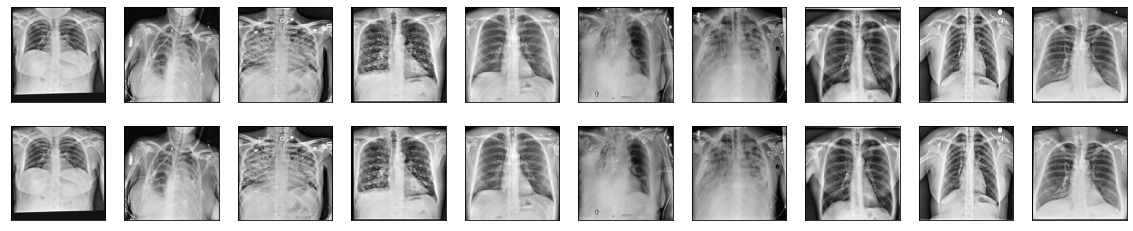

In [2]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
sz,imgs=128,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        # print('{0} {1} -> '.format(img.shape, img.dtype))
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        # print('{0} {1}'.format(img.shape, img.dtype))
        # continue
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
show_original_decoded(imgs[:10], imgs[:10], sz)

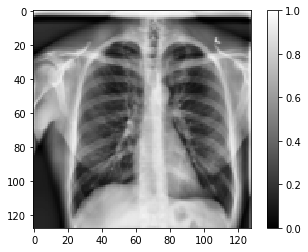

In [3]:
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Using TensorFlow backend.


In [5]:
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """Compute VAE loss, using either mse or crossentropy."""
    from tensorflow.keras.losses import mse, binary_crossentropy
    img_pixels = sz * sz
    use_mse = False
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

In [6]:
def build_autoencoder(sz, optimizer):
    from keras.layers import Dense, Input, SpatialDropout2D
    from keras.layers import Conv2D, Flatten, Lambda
    from keras.layers import LocallyConnected2D, ZeroPadding2D
    from keras.layers import MaxPooling2D, UpSampling2D
    from keras.layers import Reshape, Conv2DTranspose
    from keras.layers import ActivityRegularization
    from keras.models import Model
    from keras.datasets import mnist
    from keras.losses import mse, binary_crossentropy
    from keras.utils import plot_model

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (5,5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)  # WHAT?!?!?
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (5,5), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, 
                        loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [7]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta')
    # 'binary_crossentropy')
    # 'mean_squared_error')
    # vae_loss)

(None, 8, 8, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   4640        max_pooling2d_2[0][0]            
____________________________________________________________________________

In [8]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12072, 128, 128, 1) (1341, 128, 128, 1)


In [14]:
autoencoder.fit(x_train, x_train, 
                epochs=1024, batch_size=512, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 12072 samples, validate on 1341 samples
Epoch 1/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9316.9893 - val_loss: 9421.9151
Epoch 2/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9317.6030 - val_loss: 9421.8468
Epoch 3/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9308.3872 - val_loss: 9425.3627
Epoch 4/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9318.4875 - val_loss: 9419.6389
Epoch 5/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9313.8243 - val_loss: 9424.9810
Epoch 6/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9317.6278 - val_loss: 9414.9235
Epoch 7/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9311.2912 - val_loss: 9416.4483
Epoch 8/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9313.5015 - val_loss: 9418.7513
Epoch 9/1024
12072/12072 [=====================

12072/12072 [==============================] - 20s 2ms/step - loss: 9319.0502 - val_loss: 9433.6981
Epoch 73/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9306.5535 - val_loss: 9425.4155
Epoch 74/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9315.1000 - val_loss: 9420.9273
Epoch 75/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9311.6227 - val_loss: 9433.0753
Epoch 76/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9314.7436 - val_loss: 9416.1900
Epoch 77/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9309.1417 - val_loss: 9402.6497
Epoch 78/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9308.5421 - val_loss: 9435.9880
Epoch 79/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9313.7870 - val_loss: 9425.2575
Epoch 80/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9302.0977 - val_loss

12072/12072 [==============================] - 20s 2ms/step - loss: 9309.4242 - val_loss: 9414.3139
Epoch 144/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9305.1061 - val_loss: 9408.0617
Epoch 145/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.0857 - val_loss: 9407.8512
Epoch 146/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9304.5546 - val_loss: 9418.6132
Epoch 147/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9305.5574 - val_loss: 9407.9803
Epoch 148/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9311.5543 - val_loss: 9412.7462
Epoch 149/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9311.7815 - val_loss: 9404.9905
Epoch 150/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9305.5327 - val_loss: 9415.2266
Epoch 151/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9309.4481 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9313.2042 - val_loss: 9429.8552
Epoch 215/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9307.0239 - val_loss: 9423.0318
Epoch 216/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9305.6529 - val_loss: 9431.0389
Epoch 217/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9310.5937 - val_loss: 9413.8192
Epoch 218/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9302.0170 - val_loss: 9443.8275
Epoch 219/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9303.6314 - val_loss: 9432.1802
Epoch 220/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9314.4189 - val_loss: 9417.1038
Epoch 221/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9310.3070 - val_loss: 9441.0152
Epoch 222/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9311.6113 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9305.0048 - val_loss: 9419.7752
Epoch 286/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9300.7780 - val_loss: 9422.8134
Epoch 287/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9311.8189 - val_loss: 9445.1733
Epoch 288/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9309.1127 - val_loss: 9419.0579
Epoch 289/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9303.4294 - val_loss: 9417.1406
Epoch 290/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9310.3955 - val_loss: 9431.0722
Epoch 291/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9305.7656 - val_loss: 9428.6707
Epoch 292/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9302.7385 - val_loss: 9418.5366
Epoch 293/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9302.2064 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9304.3437 - val_loss: 9428.4033
Epoch 357/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9309.4554 - val_loss: 9420.1404
Epoch 358/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9304.4950 - val_loss: 9419.7131
Epoch 359/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.0075 - val_loss: 9431.2187
Epoch 360/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9303.2684 - val_loss: 9423.8391
Epoch 361/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9305.8471 - val_loss: 9432.5585
Epoch 362/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.6283 - val_loss: 9442.4487
Epoch 363/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9306.6372 - val_loss: 9418.8485
Epoch 364/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9308.3351 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9300.4619 - val_loss: 9432.9254
Epoch 428/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.2432 - val_loss: 9410.2063
Epoch 429/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9303.5392 - val_loss: 9430.8348
Epoch 430/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9306.9535 - val_loss: 9420.0578
Epoch 431/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9305.3115 - val_loss: 9420.6243
Epoch 432/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9304.0932 - val_loss: 9437.2816
Epoch 433/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.2079 - val_loss: 9414.7709
Epoch 434/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.1822 - val_loss: 9409.8009
Epoch 435/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9296.8452 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9297.7710 - val_loss: 9412.0380
Epoch 499/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9301.1150 - val_loss: 9418.7840
Epoch 500/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9301.0262 - val_loss: 9417.6793
Epoch 501/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9301.3318 - val_loss: 9418.7604
Epoch 502/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9308.6693 - val_loss: 9415.7021
Epoch 503/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9297.5772 - val_loss: 9427.6440
Epoch 504/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9300.3505 - val_loss: 9427.9095
Epoch 505/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9303.8594 - val_loss: 9428.8570
Epoch 506/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9307.4668 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9298.7005 - val_loss: 9424.9348
Epoch 570/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9306.1038 - val_loss: 9422.4304
Epoch 571/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9305.2922 - val_loss: 9416.6233
Epoch 572/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9303.6467 - val_loss: 9426.4307
Epoch 573/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9296.9100 - val_loss: 9436.3456
Epoch 574/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9307.7073 - val_loss: 9427.5926
Epoch 575/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9298.7406 - val_loss: 9422.3195
Epoch 576/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9293.0948 - val_loss: 9445.7632
Epoch 577/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9304.4706 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9295.5920 - val_loss: 9433.9776
Epoch 641/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9303.3031 - val_loss: 9439.3746
Epoch 642/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9302.4572 - val_loss: 9417.9872
Epoch 643/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9298.8946 - val_loss: 9416.2189
Epoch 644/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9302.3706 - val_loss: 9423.8601
Epoch 645/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9298.4000 - val_loss: 9436.5857
Epoch 646/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9298.8635 - val_loss: 9413.1878
Epoch 647/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9298.1182 - val_loss: 9427.3666
Epoch 648/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.7733 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9298.7770 - val_loss: 9436.6856
Epoch 712/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9303.0930 - val_loss: 9427.3298
Epoch 713/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9296.4815 - val_loss: 9410.4187
Epoch 714/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9290.3110 - val_loss: 9422.3224
Epoch 715/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9303.8725 - val_loss: 9432.0456
Epoch 716/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9293.3281 - val_loss: 9438.0446
Epoch 717/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.1488 - val_loss: 9429.6717
Epoch 718/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9297.3568 - val_loss: 9423.5190
Epoch 719/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9291.1884 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9293.2169 - val_loss: 9433.6675
Epoch 783/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9304.6256 - val_loss: 9427.5208
Epoch 784/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9300.9103 - val_loss: 9444.3310
Epoch 785/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9292.0823 - val_loss: 9420.2172
Epoch 786/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9293.6043 - val_loss: 9425.5284
Epoch 787/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9291.2023 - val_loss: 9415.4747
Epoch 788/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.6354 - val_loss: 9435.7277
Epoch 789/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9305.7014 - val_loss: 9450.4147
Epoch 790/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9293.3849 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9301.3235 - val_loss: 9436.9602
Epoch 854/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9299.4791 - val_loss: 9417.7510
Epoch 855/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9292.5850 - val_loss: 9427.7554
Epoch 856/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9296.4421 - val_loss: 9444.7650
Epoch 857/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9293.4563 - val_loss: 9458.8150
Epoch 858/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9300.7345 - val_loss: 9426.1475
Epoch 859/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9296.8179 - val_loss: 9449.6642
Epoch 860/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9300.9073 - val_loss: 9446.4675
Epoch 861/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.3002 - 

12072/12072 [==============================] - 20s 2ms/step - loss: 9293.8062 - val_loss: 9438.8227
Epoch 925/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9294.8472 - val_loss: 9439.0932
Epoch 926/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9291.0376 - val_loss: 9426.7074
Epoch 927/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9292.6439 - val_loss: 9417.2269
Epoch 928/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9290.2003 - val_loss: 9430.3922
Epoch 929/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9304.5748 - val_loss: 9454.6461
Epoch 930/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9298.3292 - val_loss: 9446.0971
Epoch 931/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9294.3517 - val_loss: 9449.5168
Epoch 932/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9297.7543 - 

12072/12072 [==============================] - 19s 2ms/step - loss: 9302.1081 - val_loss: 9441.3360
Epoch 996/1024
12072/12072 [==============================] - 20s 2ms/step - loss: 9292.7123 - val_loss: 9426.6747
Epoch 997/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9288.0307 - val_loss: 9431.8660
Epoch 998/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9293.3091 - val_loss: 9427.4767
Epoch 999/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9289.9122 - val_loss: 9442.2300
Epoch 1000/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9301.1468 - val_loss: 9442.5776
Epoch 1001/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9294.9920 - val_loss: 9433.5102
Epoch 1002/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9295.9431 - val_loss: 9435.0315
Epoch 1003/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 9300.314

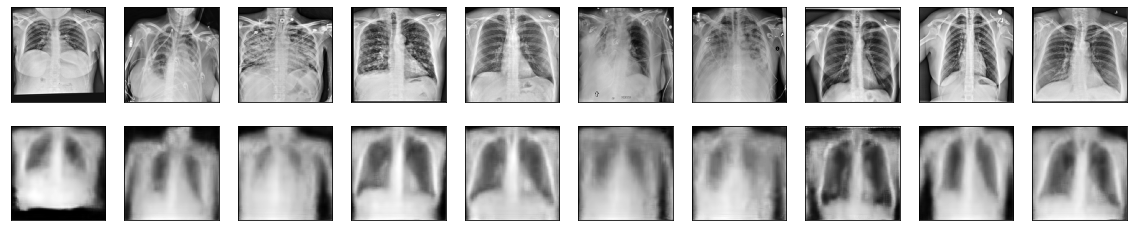

In [15]:
encode_only_imgs = encode_only.predict(x_test[:10])
if False:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [18]:
def update_image_for_sliders(**kwargs):
    import scipy
    plt.figure(2)
    latent = np.array([list(kwargs.values())])
    decoded_pixel_array = decode_only.predict(latent)
    interp_array = scipy.ndimage.zoom(decoded_pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    return kwargs['1']

In [19]:
%matplotlib inline
latent_dim = encode_only_imgs[2].shape[-1]

from ipywidgets import FloatSlider, interactive_output, Layout
kwargs = {}
for k in range(latent_dim):
    kwargs[str(k)] = \
        FloatSlider(value = 0,
                    min = -2.0, max = 2.0, 
                    step = 0.01,
                    orientation='vertical',
                    layout=Layout(padding='0%'))

slider_widgets = interactive_output(update_image_for_sliders, kwargs)
display(widgets.HBox(list(kwargs.values()), 
                     layout = Layout(padding='0%')),
        slider_widgets)

Output()